In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
%matplotlib qt
%matplotlib inline

# Function : Get binary image
## Direction of the gradient

In [2]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

## Magnitude 

In [3]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(np.square(sobely) + np.square(sobelx))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

## Absolute value of the gradient

In [4]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    assert orient == 'x' or orient == 'y', 'orient should be x or y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

## Thresholding L channel in HLS color space

In [5]:
def light_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the L channel
    L = hls[:,:,1]
    binary_output = np.zeros_like(L)
    binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

## Thresholding S channel in HLS color space

In [6]:
def satu_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# Function : Sliding Windows

In [7]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result  (unnecessary processing　)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #Find the four boundaries of the window 
        win_xleft_low = leftx_current -  margin
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin# Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image  (unnecessary processing)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # found > minpix pixels, recenter next window
        #(`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Colors in the left and right lane regions   (unnecessary processing)　
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return leftx, lefty, rightx, righty, out_img

# Function : Fit a Polynomial

In [14]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    #Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

# Function : Calculate the curvature in meters

In [9]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
  
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 33/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/729 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #Implement the calculation of R_curve (radius of curvature) 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

# Function : Calculate the vehicle position

In [10]:
def vehicle_center(ploty, left_fitx, right_fitx, xsize):
    
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/729 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.argmax(ploty)
    
    #Calculate the difference between the center of the image and the center of the lane
    linecenter = (right_fitx[y_eval] - left_fitx[y_eval]) /2 + left_fitx[y_eval]
    vehicle_posi = round((linecenter - xsize/2)*xm_per_pix,2)
    
    return vehicle_posi

# Function : Project detected lines

In [11]:
def Draw(undist_img, warped,left_fitx, right_fitx, ploty, invM):
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, invM, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    return result

# Main process to find lane

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


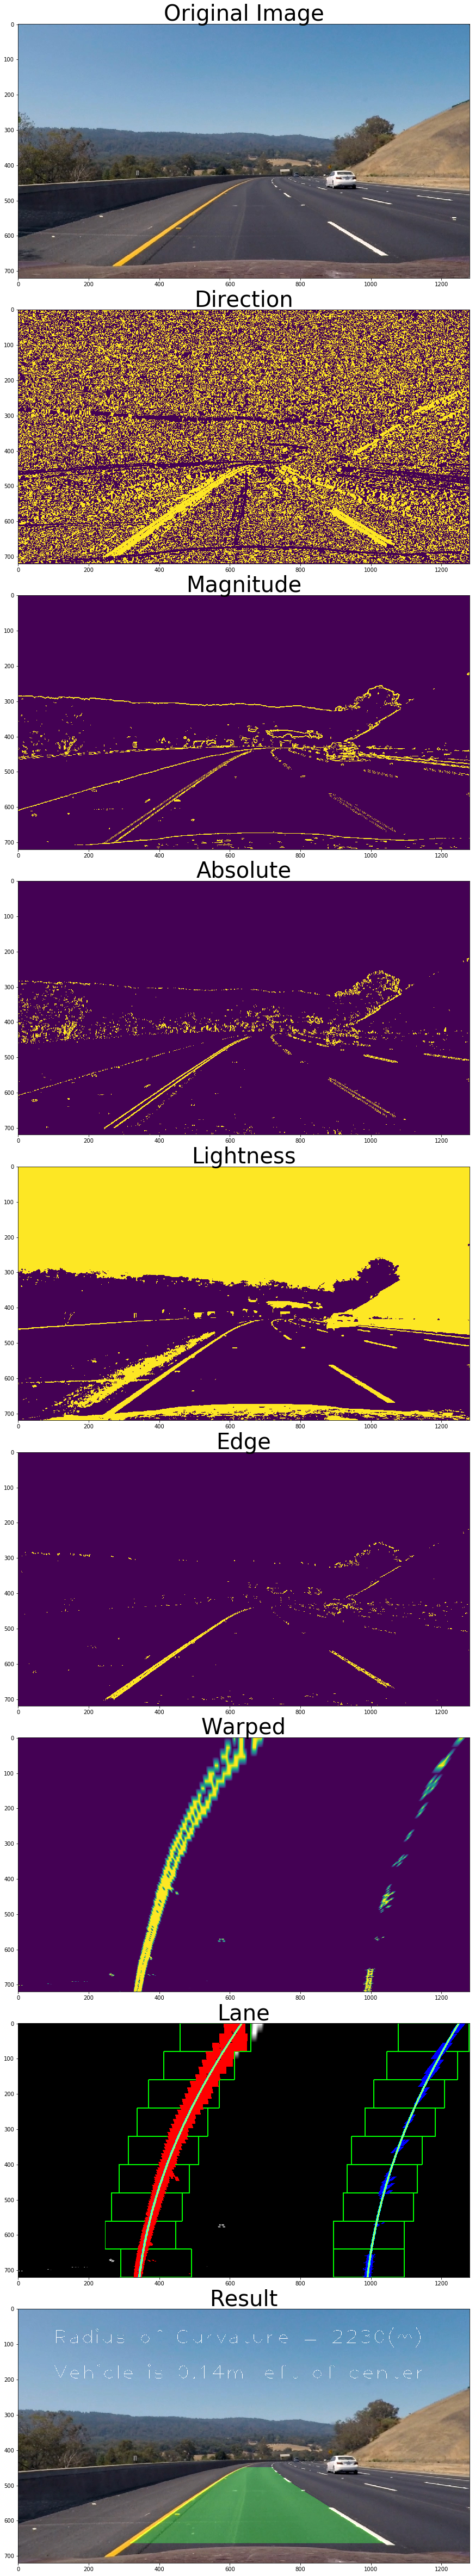

In [23]:

# 1)Read in the saved camera matrix ,distortion coefficients and  transform matrix
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = dist_pickle["M"]
invM = dist_pickle["invM"]

#2)Read image
image = mpimg.imread('test_images/test3.jpg')

img_size = (image.shape[1], image.shape[0])

#3)Undistort using mtx and dist
undist_img = cv2.undistort(image, mtx, dist, None, mtx)

#4)Get binary images
#4-1)the direction of the gradient
dir_img = dir_threshold(undist_img, sobel_kernel=15, thresh=(0.7, 1.3))
#4-2)the magnitude 
mag_img = mag_thresh(undist_img, sobel_kernel=3, mag_thresh=(30, 100))
#4-3)absolute value of the gradient
abs_img = abs_sobel_thresh(undist_img, orient='x', thresh_min=20, thresh_max=100)
#4-4)thresholding L channel in HLS color space
light_img = light_select(undist_img, thresh=(100, 255))
#4-5)thresholding S channel in HLS color space
satu_img = satu_select(undist_img, thresh=(150, 255))

#5)Combine binary images
edge_img = np.zeros_like(dir_img)
edge_img[(light_img == 1) & (dir_img == 1) & ((mag_img == 1) | (abs_img == 1) | (satu_img == 1)) ] = 1

#6)Use cv2.warpPerspective() to warp combined image to a top-down view
edge_warped = cv2.warpPerspective(edge_img, M, img_size, flags=cv2.INTER_LINEAR)

#7)Sliding Windows
leftx, lefty, rightx, righty, lane_img = find_lane_pixels(edge_warped)

#8)Fit a Polynomial
left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(lane_img.shape, leftx, lefty, rightx, righty)

#9)Calculates the curvature of polynomial functions in meters
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)
radius_of_curvature = int((left_curverad + right_curverad) / 2)

#10)Calculate the vehicle position
vehicle_posi  = vehicle_center(ploty, left_fitx, right_fitx, image.shape[1])

#11)Project detected lines onto the original image
out_img = Draw(undist_img, edge_warped,left_fitx, right_fitx, ploty, invM)

#12)Display the calculation result of the curvature in 'out_img'
text = 'Radius of Curvature = ' + str(radius_of_curvature) + '(m)'
cv2.putText(out_img,text,(100,100),cv2.FONT_HERSHEY_PLAIN, 4,(255,255,255))

#13)Display the calculation result of the vehicle position in 'out_img'
if vehicle_posi < 0:
    text2 = 'Vehicle is ' + str(-1*vehicle_posi) + 'm right of center'
elif vehicle_posi > 0:
    text2 = 'Vehicle is ' + str(vehicle_posi) + 'm left of center'
else:
    text2 = 'Vehicle is center'
cv2.putText(out_img,text2,(100,200),cv2.FONT_HERSHEY_PLAIN, 4,(255,255,255))


#Draw thick line on the 'lane_img'    (unnecessary processing)
lane_img[[int(ly) for ly in ploty], [int(l-3) for l in left_fitx]] = [0, 255, 255]
lane_img[[int(ry) for ry in ploty], [int(r-3) for r in right_fitx]] = [0, 255, 255]
lane_img[[int(ly) for ly in ploty], [int(l-2) for l in left_fitx]] = [0, 255, 255]
lane_img[[int(ry) for ry in ploty], [int(r-2) for r in right_fitx]] = [0, 255, 255]
lane_img[[int(ly) for ly in ploty], [int(l-1) for l in left_fitx]] = [0, 255, 255]
lane_img[[int(ry) for ry in ploty], [int(r-1) for r in right_fitx]] = [0, 255, 255]
lane_img[[int(ly) for ly in ploty], [int(l) for l in left_fitx]] = [0, 255, 255]
lane_img[[int(ry) for ry in ploty], [int(r) for r in right_fitx]] = [0, 255, 255]
lane_img[[int(ly) for ly in ploty], [int(l+1) for l in left_fitx]] = [0, 255, 255]
lane_img[[int(ry) for ry in ploty], [int(r+1) for r in right_fitx]] = [0, 255, 255]
lane_img[[int(ly) for ly in ploty], [int(l+2) for l in left_fitx]] = [0, 255, 255]
lane_img[[int(ry) for ry in ploty], [int(r+2) for r in right_fitx]] = [0, 255, 255]
lane_img[[int(ly) for ly in ploty], [int(l+3) for l in left_fitx]] = [0, 255, 255]
lane_img[[int(ry) for ry in ploty], [int(r+3) for r in right_fitx]] = [0, 255, 255]

#Save result images   (unnecessary processing)
out_img_bgr = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/test3_direction.jpg",dir_img*255)
cv2.imwrite("test_images_output/test3_magnitude.jpg",mag_img*255)
cv2.imwrite("test_images_output/test3_absolute.jpg",abs_img*255)
cv2.imwrite("test_images_output/test3_lightness.jpg",light_img*255)
cv2.imwrite("test_images_output/test3_edge.jpg",edge_img*255)
cv2.imwrite("test_images_output/test3_warped.jpg",edge_warped*255)
cv2.imwrite("test_images_output/test3_lane.jpg",lane_img)
cv2.imwrite("test_images_output/test3_result.jpg",out_img_bgr)

# Plot the result (unnecessary processing)
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, 1, figsize=(96, 36))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(dir_img)
ax2.set_title('Direction', fontsize=40)

ax3.imshow(mag_img)
ax3.set_title('Magnitude', fontsize=40)

ax4.imshow(abs_img)
ax4.set_title('Absolute', fontsize=40)

ax5.imshow(light_img)
ax5.set_title('Lightness', fontsize=40)

ax6.imshow(edge_img)
ax6.set_title('Edge', fontsize=40)

ax7.imshow(edge_warped)
ax7.set_title('Warped', fontsize=40)

ax8.plot(left_fitx, ploty, color='yellow')
ax8.plot(right_fitx, ploty, color='yellow')
ax8.imshow(lane_img)
ax8.set_title('Lane', fontsize=40)

ax9.imshow(out_img)
ax9.set_title('Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)